# References
- https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00
- https://towardsdatascience.com/steam-recommendation-systems-4358917288eb
- https://towardsdatascience.com/explain-your-machine-learning-with-feature-importance-774cd72abe
- https://pbpython.com/categorical-encoding.html
- https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae

In [73]:
import ast
import json
import re
import csv
import pandas as pd
import numpy as np
import os, io
import csv
import matplotlib.pyplot as plt

- Inherited data was not in valid json format
- It had multiple issues like the following:
    - keys enclosed in single quotes instead of double quotes
    - Invalid characters in data
    - Nested quotes needed to be handled
    - Invalid json formatting
- Reviewed raw data, identified issues and developed a python script to clean it
- Repeated the steps for user-item data and item-metadata

In [407]:
# Clean user-item data
def clean_data():
    count_err = 0
    count = 0
    with open("australian_users_items.json", "r") as raw_input:
        with open("australian_users_items_formatted.json", "w") as cleaned_file:
            try:
                #cleaned_file.write("[")
                for line in raw_input:
                    #print(line)
                    withoutSingleQuotes = line.replace('\'', '\"')
                    main_item_name_indexes = [m.start() for m in re.finditer('item_name', withoutSingleQuotes)]
                    for main_item_name_index in main_item_name_indexes:
                        main_item_name_index = main_item_name_index + 13
                        current_play_index = withoutSingleQuotes[main_item_name_index:].find("playtime_forever")
                        temp = withoutSingleQuotes[main_item_name_index: main_item_name_index + current_play_index - 4 ]
                        repeatingDoubleQuotesIndexes = [m.start() for m in re.finditer("\"", temp)]
                        for i in repeatingDoubleQuotesIndexes:
                            toReplaceIndex = main_item_name_index + i
                            withoutSingleQuotes = withoutSingleQuotes[:toReplaceIndex] + "'" + withoutSingleQuotes[toReplaceIndex + 1:]
                    cleaned_file.write(withoutSingleQuotes)
                    #count += 1
                #cleaned_file.write("]")
            except:
                #count_err += 1
                pass
    #print(count, count_err)
if __name__ == "__main__":
    clean_data()

count = 0
users = []
items = []
with open("australian_users_items.json", "r") as raw_input:
    line = raw_input.readline()
    while(line):
        try:
            count += 1
            print(count)
            line = raw_input.readline()
        except:
            print(line)
            pass

- Each data file had its own problems
- Hence, some modifications along with a thorough review were required for every data file

In [3]:
# clean item metadata
aberrations = []
def clean_item_metadata():
    count = 0
    with open("item_metadata.json", "r") as raw_input:
        with open("item_metadata_formatted.json", "w") as cleaned_file:
            try:
                for line in raw_input:
                    #print(line)
                    #txt = "\"The rain in Spain\""
                    x = re.search(".*\".*'.*\"", line)
                    if x:
                        #print("YES! We have a match!")
                        aberrations.append(line)
                    else:
                        count += 1
                        withoutSingleQuotes = line.replace('\'', '\"')
                        withoutBackSlashes = withoutSingleQuotes.replace('\\', '')
                    cleaned_file.write(withoutBackSlashes)
            except Exception as e:
                print(e)
                pass
    print(count)
if __name__ == "__main__":
    clean_item_metadata()

29257


- Read the data cleaned by the above scripts
- Analyze the required attributes and load them into a dataframe

In [4]:
# Load user-item to a data frame
users = []
items = []
playtimes = []
with open("australian_users_items_formatted.json", "r") as users_items:
    for line in users_items:
        data = json.loads(line)
        for item in data['items']:
            users.append(data['steam_id'])
            items.append(item['item_id'])
            playtimes.append(item['playtime_forever'])
df = pd.DataFrame({"steam_id":users,"item_id":items,"playtime":playtimes})
print(df.shape)
df.head()

(17122, 3)


,steam_id,item_id,playtime
0,76561197970982479,10,6
1,76561197970982479,20,0
2,76561197970982479,30,7
3,76561197970982479,40,0
4,76561197970982479,50,0


- Top userid-itemid pairs in terms of playtime

In [385]:
# The following code can be used to scale the playtime
#col = 'playtime'
#df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
#df['playtime'].value_counts()
df.sort_values('playtime',ascending=False).head()

,steam_id,item_id,playtime
9010,76561198078738103,4000,303466
4645,76561198010803705,4000,255613
5169,76561198018556265,4000,243840
6832,76561198096285145,550,184933
15608,76561198066728567,730,172753


- Item metadata was more important for analysing feature importance
- Approach:
    - Load json data
    - Extract all data into a data frame
    - Convert "genre" and "spec" attributes into multiple binary features
    - Load all features into a dataframe for rich vector representation
- Statistics:
    - Item data comprised of 22 different genres
    - Item data comprised of 31 different specification points
    - There were other attributes like "tags" in the item metadata which were ignored
    - Tags seemed repetitive and random or user-initiated
- Item Data Size:
    - Columns/Features = 57
    - Rows/Records = 29941

In [284]:
# load item metadata to a dataframe
f = open("item_metadata_formatted.json", "r")
json_data = json.loads(f.read())
itemids = []
itemgenres = []
itempublisher = []
itemdeveloper = []
itemspec = []
itemtitles = []
genreDict = {}
#generate a dictionary for genres
for s in ['strategy', 'animation_&amp;_modeling', 'photo_editing', 'software_training', 'sports', 'web_publishing', 'accounting', 'free_to_play', 'indie', 'utilities', 'simulation', 'education', 'action', 'massively_multiplayer', 'audio_production', 'design_&amp;_illustration', 'casual', 'early_access', 'racing', 'adventure', 'rpg', 'video_production']:
    genreDict["genre_"+s] = [0]*29941
specDict = {}
#generate a dictionary for specs
for s in ['full_controller_support', 'commentary_available', 'partial_controller_support', 'valve_anti-cheat_enabled', 'local_co-op', 'game_demo', 'steam_turn_notifications', 'steam_cloud', 'steam_achievements', 'includes_source_sdk', 'includes_level_editor', 'cross-platform_multiplayer', 'mmo', 'steam_leaderboards', 'shared/split_screen', 'mods_(require_hl2)', 'local_multi-player', 'in-app_purchases', 'co-op', 'steamvr_collectibles', 'online_multi-player', 'steam_workshop', 'multi-player', 'online_co-op', 'downloadable_content', 'stats', 'mods', 'captions_available', 'mods_(require_hl1)', 'single-player', 'steam_trading_cards']:
    specDict["spec_"+s] = [0]*29941
#print(genreDict)
count = -1
#uniqueGenres = set()
#uniqueSpecs = set()

for item in json_data:
        if "title" in item.keys():
            count += 1
            if(item.get('title')):
                itemtitles.append(item.get('title'))
            else:
                continue
            if(item.get('id')):
                itemids.append(item.get('id'))
            else:
                continue
            if(item.get('genres')):
                for i in item.get('genres'):
                    genreDict["genre_"+i.strip().lower().replace(" ","_")][count] = 1
                #print(item.get('genres'))
                itemgenres.append(item.get('genres'))
            else:
                itemgenres.append("")
            if(item.get('publisher')):
                itempublisher.append(item.get('publisher'))
            else:
                itempublisher.append("")
            if(item.get('developer')):
                itemdeveloper.append(item.get('developer'))
            else:
                itemdeveloper.append("")
            if(item.get('specs')):
                for i in item.get('specs'):
                    specDict["spec_"+i.strip().lower().replace(" ","_")][count] = 1
                itemspec.append(item.get('specs'))
            else:
                itemspec.append("")
dfDict = {"item_id":itemids,"publisher":itempublisher,"developer":itemdeveloper, "title": itemtitles} #"genres":itemgenres,"specs":itemspec}
for key in genreDict:
    dfDict[key] = genreDict[key]
for key in specDict:
    dfDict[key] = specDict[key]
#print(dfDict.keys())
itemdf = pd.DataFrame(dfDict)
#genredfcolumns = {'strategy', 'animation_&amp;_modeling', 'photo_editing', 'software_training', 'sports', 'web_publishing', 'accounting', 'free_to_play', 'indie', 'utilities', 'simulation', 'education', 'action', 'massively_multiplayer', 'audio_production', 'design_&amp;_illustration', 'casual', 'early_access', 'racing', 'adventure', 'rpg', 'video_production'}
#specdfcolumns = {'full_controller_support', 'commentary_available', 'partial_controller_support', 'valve_anti-cheat_enabled', 'local_co-op', 'game_demo', 'steam_turn_notifications', 'steam_cloud', 'steam_achievements', 'includes_source_sdk', 'includes_level_editor', 'cross-platform_multiplayer', 'mmo', 'steam_leaderboards', 'shared/split_screen', 'mods_(require_hl2)', 'local_multi-player', 'in-app_purchases', 'co-op', 'steamvr_collectibles', 'online_multi-player', 'steam_workshop', 'multi-player', 'online_co-op', 'downloadable_content', 'stats', 'mods', 'captions_available', 'mods_(require_hl1)', 'single-player', 'steam_trading_cards'}
print(itemdf.shape)
#print(len(uniqueGenres), len(uniqueSpecs))
#print(uniqueGenres)
#print(uniqueSpecs)
itemdf.head()

(29941, 57)


,item_id,publisher,developer,title,genre_strategy,genre_animation_&amp;_modeling,genre_photo_editing,genre_software_training,genre_sports,genre_web_publishing,...,spec_steam_workshop,spec_multi-player,spec_online_co-op,spec_downloadable_content,spec_stats,spec_mods,spec_captions_available,spec_mods_(require_hl1),spec_single-player,spec_steam_trading_cards
0,761140,Kotoshiro,Kotoshiro,Lost Summoner Kitty,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,643980,"Making Fun, Inc.",Secret Level SRL,Ironbound,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
2,670290,Poolians.com,Poolians.com,Real Pool 3D - Poolians,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,767400,u5f7cu5cb8u9886u57df,u5f7cu5cb8u9886u57df,u5f39u70b8u4eba2222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,772540,Trickjump Games Ltd,Trickjump Games Ltd,Battle Royale Trainer,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Form clusters using KMeans algorithm
- Genre and Spec features are binary
- KMeans works best for features having continuous values
- Expectedly, KMeans was not helpful in generating any meaningful clusters

In [6]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 10)
temp_itemdf = itemdf.drop(['item_id','publisher','developer'],axis=1)
km.fit(temp_itemdf)

prediction = km.predict(temp_itemdf)

- List feature clusters detected using KMeans
- As can be seen in the below output, all features are part of every cluster
- This result is poor and does not help us

In [9]:
centroids = km.cluster_centers_
shape = centroids.shape
#print(shape, centr)
for i in range(shape[0]):
    if sum(centroids[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = centroids[i,:]
        for j in temp_itemdf.columns[np.nonzero(cent)]:
            #print(" ".join(j.split("_")[1:]))
            print(j)


cluster 0: 
genre_strategy
genre_animation_&amp;_modeling
genre_photo_editing
genre_software_training
genre_sports
genre_web_publishing
genre_accounting
genre_free_to_play
genre_indie
genre_utilities
genre_simulation
genre_education
genre_action
genre_massively_multiplayer
genre_audio_production
genre_design_&amp;_illustration
genre_casual
genre_early_access
genre_racing
genre_adventure
genre_rpg
genre_video_production
spec_full_controller_support
spec_commentary_available
spec_partial_controller_support
spec_valve_anti-cheat_enabled
spec_local_co-op
spec_game_demo
spec_steam_turn_notifications
spec_steam_cloud
spec_steam_achievements
spec_includes_source_sdk
spec_includes_level_editor
spec_cross-platform_multiplayer
spec_mmo
spec_steam_leaderboards
spec_shared/split_screen
spec_mods_(require_hl2)
spec_local_multi-player
spec_in-app_purchases
spec_co-op
spec_steamvr_collectibles
spec_online_multi-player
spec_steam_workshop
spec_multi-player
spec_online_co-op
spec_downloadable_content


- Merge dataframes to collate user-item and item metadata
- This provides us with a richer dataset and better possibilities of visualisation

In [390]:
megadf = pd.merge(df, itemdf.drop(columns=['publisher','developer']), how='inner', on='item_id', left_on=None, right_on=None,
         left_index=True, right_index=True, sort=False,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
megadf.head()

,steam_id,item_id,playtime,title,genre_strategy,genre_animation_&amp;_modeling,genre_photo_editing,genre_software_training,genre_sports,genre_web_publishing,...,spec_steam_workshop,spec_multi-player,spec_online_co-op,spec_downloadable_content,spec_stats,spec_mods,spec_captions_available,spec_mods_(require_hl1),spec_single-player,spec_steam_trading_cards
0,76561197970982479,10,6,Lost Summoner Kitty,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,76561197970982479,20,0,Ironbound,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
2,76561197970982479,30,7,Real Pool 3D - Poolians,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,76561197970982479,40,0,u5f39u70b8u4eba2222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,76561197970982479,50,0,Battle Royale Trainer,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [62]:
megadf.to_csv("item-genre-spec-playtime.csv",index=False)

In [392]:
# Naturally, some items which have never been purchased by a user get dropped in merging data
# This is required so that we can associate playtime with items as our target feature
megadf.shape

(17122, 57)

- Remove outliers which might adversely affect cluster
- For example, extreme playtimes which have a frequency of less than  players
- Replace such playtimes with null so that they won't be considered in calculation

In [395]:
#Remove outliers (rows with abnormal or singular play times)
v = megadf[['playtime']]
tempdf = megadf[v.replace(v.stack().value_counts()).gt(2).all(1)] #['playtime'].value_count()
megadf['playtime'].value_counts()
megadf.shape

(17122, 57)

# Random Forest Classifier
- Use Random Forest Classifier to find feature importance w.r.t target feature
- Target feature will be 'playtime' as that is the only measurable feature which can be used to rate an item

In [348]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#from sklearn.metrics import plot_roc_curve

y=tempdf['playtime']
X=tempdf.drop(columns=['playtime','steam_id','item_id','title'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [349]:
rf=RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
cf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
y_pred_test = rf.predict(X_test)
cf_matrix_test = metrics.confusion_matrix(y_test, y_pred_test)

In [350]:
print('Training set metrics:')
print('Accuracy:', metrics.accuracy_score(y_train, y_pred_train))
print('Precision:', metrics.precision_score(y_train, y_pred_train, average='weighted'))
print('Recall:', metrics.recall_score(y_train, y_pred_train, average='weighted'))
print('Test Set Confusion Matrix: ', cf_matrix_train)

print('Test set metrics:')
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_test))
print('Precision:', metrics.precision_score(y_test, y_pred_test, average='weighted'))
print('Recall:', metrics.recall_score(y_test, y_pred_test, average='weighted'))
print('Test Set Confusion Matrix: ', cf_matrix_test)

Training set metrics:
Accuracy: 0.6037579441834761
Precision: 0.668784955679963
Recall: 0.6037579441834761
Test Set Confusion Matrix:  [[4165    9    5 ...    0    0    0]
 [ 134   82    0 ...    0    0    0]
 [  43    0   41 ...    0    0    0]
 ...
 [   0    0    0 ...    2    0    0]
 [   1    0    0 ...    0    1    0]
 [   1    0    0 ...    0    0    0]]
Test set metrics:
Accuracy: 0.331306990881459
Precision: 0.1656534954407295
Recall: 0.331306990881459
Test Set Confusion Matrix:  [[1199    2    4 ...    0    0    0]
 [  62    0    1 ...    0    0    0]
 [  22    1    0 ...    0    0    0]
 ...
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#import seaborn as sns
sns.heatmap(cf_matrix_test, annot=True)

- Display importance factor for each feature
- Features being evaluated are genre and spec
- This will help us gain an insight into the types of games liked by users
- This data can further be validated against bundles of games which have been formed

In [376]:
#sort columns by importance and feed to a dataframe for further visualization
col_sorted_by_importance=rf.feature_importances_.argsort()
#print(col_sorted_by_importance)
feat_imp=pd.DataFrame({
    'cols':X.columns[col_sorted_by_importance],
    'imps':rf.feature_importances_[col_sorted_by_importance]
})
feat_imp

,cols,imps
0,spec_mods_(require_hl1),0.000000
1,spec_mods_(require_hl2),0.000027
2,spec_steamvr_collectibles,0.000225
3,spec_mods,0.000336
4,genre_accounting,0.000499
5,genre_photo_editing,0.001104
6,spec_includes_source_sdk,0.001142
7,genre_education,0.001334
8,genre_software_training,0.001473
9,genre_video_production,0.001760


- As seen in the below bar graph, some genres and specs are much more important according to user preferences
- These features will help a game standout and is a good indicator for developers/publishers for predicting sales and budget for a game

<BarContainer object of 53 artists>

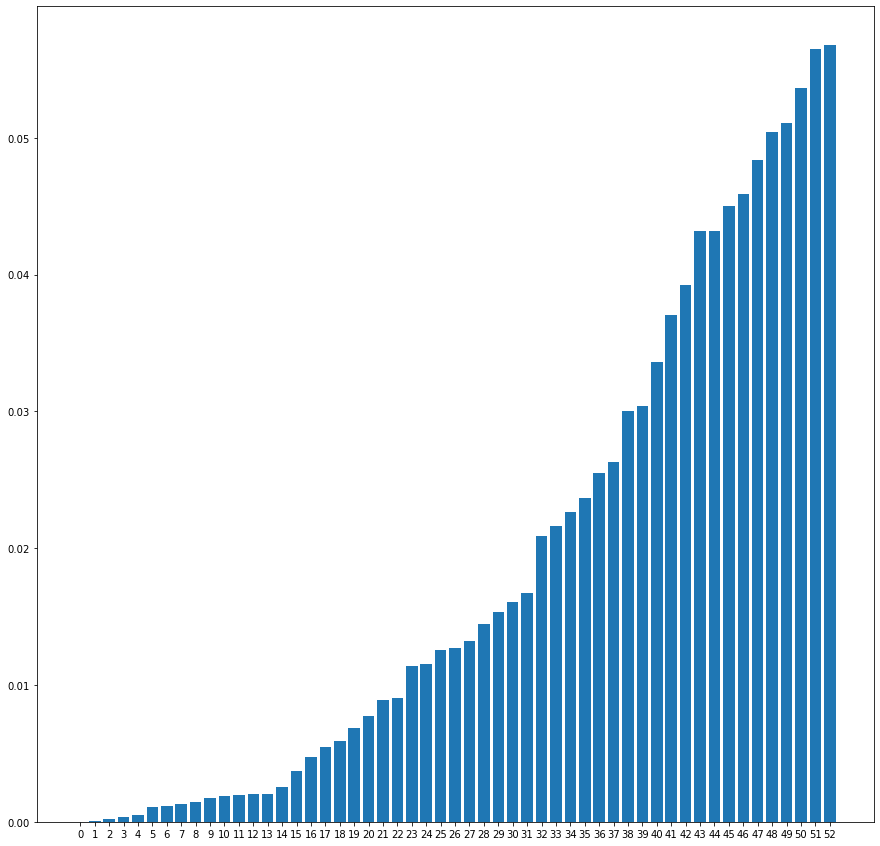

In [377]:
#import plotly_express as px
features = [i for i in range(53)]
plt.figure(figsize=(15,15))
plt.xticks(features, features)
plt.bar('cols','imps',data=feat_imp)

- Run KModes algorithm by varying parameters
- Find optimal point from the graph and build final model

Clusters =  1
Best run was number 1
Clusters =  5
Best run was number 10
Clusters =  9
Best run was number 4
Clusters =  13
Best run was number 8
Clusters =  17
Best run was number 10


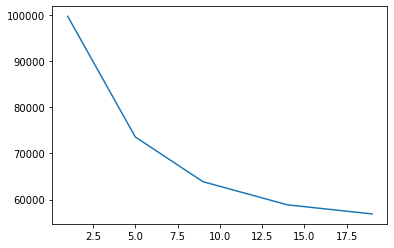

In [89]:
#https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae
from kmodes.kmodes import KModes
# define the k-modes model
compute_costs = []
for i in range(1,20,4):
    print("Clusters = ",i)
    modes = KModes(n_clusters=i, init='Huang', n_init=11, verbose=1, n_jobs=2)
    # fit the clusters to the skills dataframe
    clusters = modes.fit_predict(megadf.drop(columns=['steam_id','item_id','playtime','title'], axis=1))
    compute_costs.append(modes.cost_)
y = np.array([1,5,9,14,19])
plt.plot(y,compute_costs)

In [90]:
# build clusters on optimal model
modes_model = KModes(n_clusters=14, init='Huang', n_init=11, verbose=1, n_jobs=2)
clusters = modes_model.fit_predict(megadf.drop(columns=['steam_id','item_id','playtime','title'], axis=1))

Best run was number 2


- List features of each cluster
- Later, compare the popularity of each cluster

In [314]:
mode_centroids = modes_model.cluster_centroids_
shape = mode_centroids.shape
#print(shape, kmodes)
#print(kmodes)
cluster_groups = []
for i in range(shape[0]):
    cluster_groups.append([])
    if sum(mode_centroids[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-genre no-spec cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = mode_centroids[i,:]
        for j in megadf.drop(columns=['steam_id','item_id','playtime','title']).columns[np.nonzero(cent)]:
            print(j)
            cluster_groups[i].append(j)


cluster 0: 
genre_strategy
genre_indie
spec_steam_achievements
spec_single-player
spec_steam_trading_cards

cluster 1: 
genre_indie
genre_adventure
spec_full_controller_support
spec_steam_cloud
spec_steam_achievements
spec_single-player
spec_steam_trading_cards

cluster 2: 
genre_simulation
spec_partial_controller_support
spec_downloadable_content
spec_single-player

cluster 3: 
genre_indie
genre_adventure
spec_single-player

cluster 4: 
genre_action
spec_full_controller_support
spec_steam_cloud
spec_steam_achievements
spec_multi-player
spec_downloadable_content
spec_single-player
spec_steam_trading_cards

cluster 5: 
genre_simulation
genre_casual
spec_partial_controller_support
spec_steam_cloud
spec_steam_achievements
spec_steam_leaderboards
spec_shared/split_screen
spec_downloadable_content
spec_single-player
spec_steam_trading_cards

cluster 6: 
spec_single-player

cluster 7: 
spec_co-op
spec_multi-player
spec_downloadable_content
spec_single-player

cluster 8: 
genre_indie
genre_a

- Vectorize cluster groups into unique vectors
- These verctors will be used for finding the K nearest clusters for an existing or relatively new user

In [316]:
for i in range(len(cluster_groups)):
    curr = []
    for col in megadf.drop(columns=['steam_id','item_id','playtime','title']).columns:
        if col in cluster_groups[i]:
            curr.append(1)
        else:
            curr.append(0)
    cluster_groups[i] = curr
    #print(len(cluster_groups[i]))
#np_cluster_groups = 
#print(cluster_groups)

- Merge cluster groups with original dataframe
- This will give an indication of the nearest cluster for each existing user-item pair

In [305]:
clusterdf = pd.DataFrame(clusters)
clusterdf.columns = ['cluster_id']
cluster_megadf = pd.concat([megadf, clusterdf], axis=1)

- Combine dataframes for aggregated data
- Use this dataframe for recommendations later

In [306]:
cluster_megadf

,steam_id,item_id,playtime,title,genre_strategy,genre_animation_&amp;_modeling,genre_photo_editing,genre_software_training,genre_sports,genre_web_publishing,...,spec_multi-player,spec_online_co-op,spec_downloadable_content,spec_stats,spec_mods,spec_captions_available,spec_mods_(require_hl1),spec_single-player,spec_steam_trading_cards,cluster_id
0,76561197970982479,10,6,Lost Summoner Kitty,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,9
1,76561197970982479,20,0,Ironbound,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,76561197970982479,30,7,Real Pool 3D - Poolians,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,3
3,76561197970982479,40,0,u5f39u70b8u4eba2222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3
4,76561197970982479,50,0,Battle Royale Trainer,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17117,76561198059515552,47790,0,MechDefender,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
17118,76561198059515552,47830,0,Romance of the Three Kingdoms u2163 with Power...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,6
17119,76561198059515552,261030,0,RPG Maker MV - SAKAN,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,2
17120,76561198059515552,222900,0,Cyberline Racing,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,9


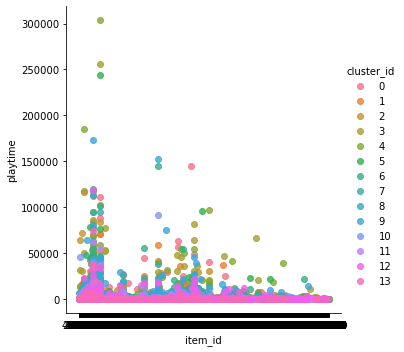

In [331]:
#plt.figure(figsize=(15,8))
#plt.scatter(cluster_megadf['cluster_id'], cluster_megadf['playtime'], s=30)

import seaborn as sns
facet = sns.lmplot(data=cluster_megadf, x='item_id', y='playtime', hue='cluster_id', 
                   fit_reg=False, legend=True, legend_out=True)

# Number of items/games in each cluster

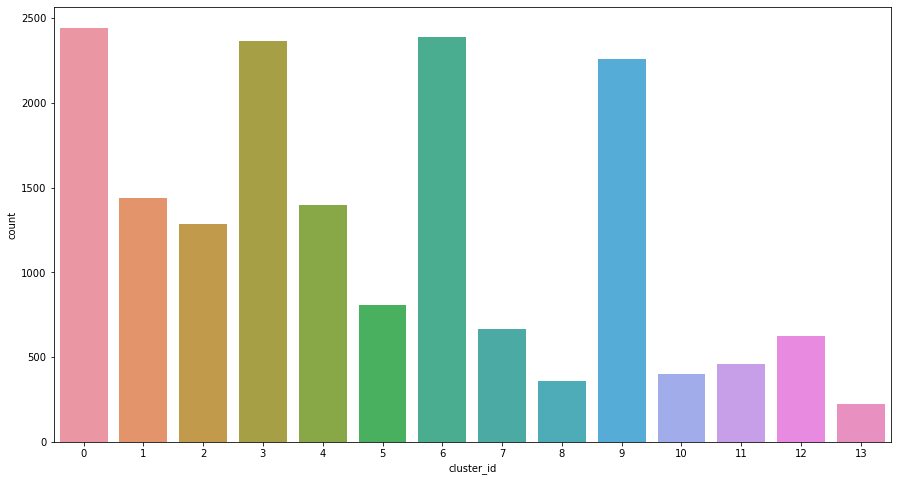

In [307]:
import seaborn as sns
plt.figure(figsize=(15,8))
ax = sns.countplot(x="cluster_id", data=cluster_megadf)

# Cluster popularity by playtime

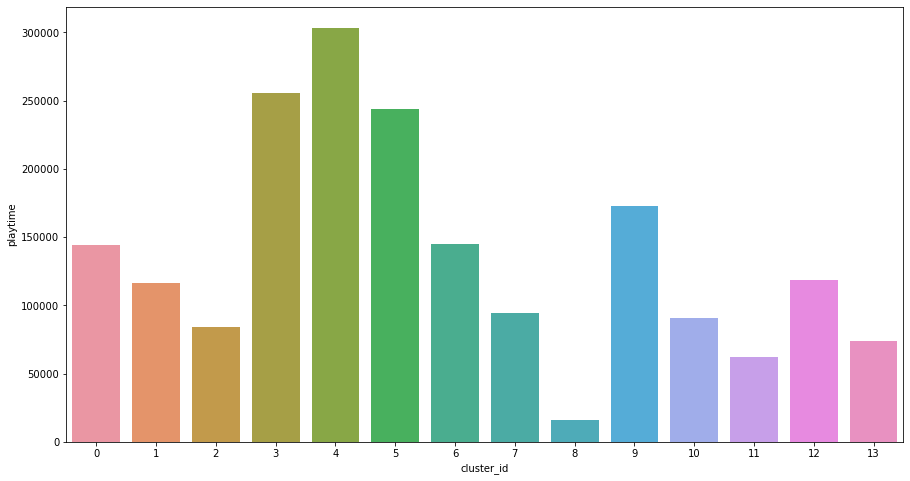

In [369]:
maxvals_clusterid = cluster_megadf.groupby('cluster_id').max()
plt.figure(figsize=(15,8))
sns.barplot(x=maxvals_clusterid.index, y=maxvals_clusterid['playtime'], data=maxvals_clusterid)

In [317]:
new_user = cluster_megadf.iloc[15932][4:-1].values

In [318]:
from sklearn.neighbors import NearestNeighbors

cluster_groups.append(new_user)

In [319]:
print(len(cluster_groups))
n = 4
np_cluster_groups = np.array(cluster_groups)
#print(np_cluster_groups)
knn = NearestNeighbors(n_neighbors=n)
knn.fit(np_cluster_groups)
x = knn.kneighbors()
y = min(x[0][-1])
closest_cluster = 0
for i in range(n):
    if x[0][-1][i] == y:
        closest_cluster = x[1][-1][i]
        break
print("User must be recommended top items from cluster ",closest_cluster)

15
User must be recommended top items from cluster  1


# Top20 Recommendations
- Based on the user's feature vector, recommend the top 20 games for this user

In [321]:
cluster_megadf.loc[cluster_megadf['cluster_id'] == closest_cluster, ['item_id','title','playtime']].sort_values('playtime',ascending=False).head(20)
#cluster_megadf.groupby('cluster_id') #.reset_index()

,item_id,title,playtime
13711,550,The Inner World - The Last Wind Monk,116186
8854,4000,Catsby,70973
11833,230410,CrazyCar - Images and Music,59201
13119,730,Harvest Moon: Light of Hope,51143
10167,730,Shephy,46486
9647,105600,OneShot Solstice OST,44742
16145,730,CW: Chaco War,43094
13617,4000,AER Memories of Old,38816
3731,214850,Official Guide - Millennium 4,37077
6722,252950,Road to Ballhalla,35998
